# Model Output Data Visualization

### Read Me

This notebook vizualizes model outputs for supervised neural methods from the rPPG Toolbox. To use this notebook follow the following steps:

* STEP 1: Specify the `TEST.OUTPUT_SAVE_DIR` field in the `.yaml` config file of a neural method experiment.
* STEP 2: Run the neural method experiment. A `.pickle` file containing the test-data predictions and labels will be created in `TEST.OUTPUT_SAVE_DIR`.
* STEP 3: Add the path to the `pickle` file in the `TODO: Variable to Set` section as `data_out_path`.
* STEP 4: Add values for `trial_idx` (a value between 0 and the `Num Trials` print in the previous cell), `chunk_size` (number of samples to plot out), `chunk_num` (the chunk of size `chunk_size` in the signal). We suggest using the defaults at first.
* STEP 5: Run all cells. The predicted output, plotted against the ground truth ppg waveform, will be plotted in the final cell

### Imports

In [1]:
# !pip install natsort
!pip install scipy
# !pip install natsort
# !pip install ipywidgets

import cv2
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import glob

import torch

import numpy as np
# import ipywidgets as widgets
from IPython.display import display, clear_output
from natsort import natsorted
import os
import scipy
from scipy.sparse import spdiags
from scipy.signal import butter
import math
from scipy import linalg
from scipy import signal
from scipy import sparse

### Helper Functions

In [15]:
# HELPER FUNCTIONS

def _reform_data_from_dict(data, flatten=True):
    """Helper func for calculate metrics: reformat predictions and labels from dicts. """
    sort_data = sorted(data.items(), key=lambda x: x[0])
    sort_data = [i[1] for i in sort_data]
    sort_data = torch.cat(sort_data, dim=0)

    if flatten:
        sort_data = np.reshape(sort_data.cpu(), (-1))
    else:
        sort_data = np.array(sort_data.cpu())

    return sort_data

def _process_signal(signal, fs=30, diff_flag=True,use_bandpass=True):
    # Detrend and filter
    use_bandpass = True
    if diff_flag:  # if the predictions and labels are 1st derivative of PPG signal.
        gt_bvp = _detrend(np.cumsum(signal), 100)
    else:
        gt_bvp = _detrend(signal, 100)
    if use_bandpass:
        # bandpass filter between [0.75, 2.5] Hz
        # equals [45, 150] beats per min
        [b, a] = butter(1, [0.75 / fs * 2, 2.5 / fs * 2], btype='bandpass')
        signal = scipy.signal.filtfilt(b, a, np.double(signal))
    return signal

def _detrend(input_signal, lambda_value):
    """Detrend PPG signal."""
    signal_length = input_signal.shape[0]
    # observation matrix
    H = np.identity(signal_length)
    ones = np.ones(signal_length)
    minus_twos = -2 * np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = spdiags(diags_data, diags_index,
                (signal_length - 2), signal_length).toarray()
    detrended_signal = np.dot(
        (H - np.linalg.inv(H + (lambda_value ** 2) * np.dot(D.T, D))), input_signal)
    return detrended_signal


### TODO: Variables To Set

In [9]:
data_out_paths = glob.glob(r"../../runs/exp/MCD*/saved_test_outputs/*.pickle")
trial_idx =4
chunk_size = 7*30 # size of chunk to visualize: -1 will plot the entire signal
chunk_num = 0

### Read Data, and Extract Trials List

In [5]:
# Read in data and list subjects
data_list = []
for i in data_out_paths:
    with open(i, 'rb') as f:
        data_list.append(pickle.load(f))
        
    # List of all video trials
    trial_list = list(data_list[0]['predictions'].keys())
print('Num Trials', len(trial_list))

Num Trials 10


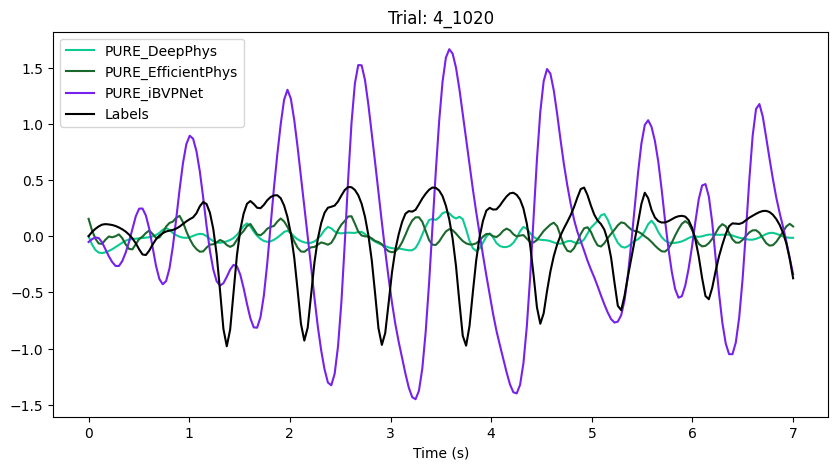

In [17]:
# Reform label and prediction vectors from multiple trial chunks
import random
from torch import randint


predictions = [np.array(_reform_data_from_dict(data['predictions'][trial_list[trial_idx]])) for data in data_list]
names = [ '_'.join(x.split('_')[:2]) for x in map(lambda x: x.split(os.sep)[-1],data_out_paths)]
names.append('Labels')
label = np.array(_reform_data_from_dict(data_list[0]['labels'][trial_list[trial_idx]]))
label = _process_signal(label, 30, diff_flag=True)
plt.figure(figsize=(10,5))
for prediction,data in zip(predictions,data_list):
    # Read in meta-data from pickle file
    fs = data['fs'] # Video Frame Rate
    label_type = data['label_type'] # PPG Signal Transformation: `DiffNormalized` or `Standardized`
    diff_flag = (label_type == 'DiffNormalized')

    if chunk_size == -1:
        chunk_size = len(prediction)
        chunk_num = 0

    # Process label and prediction signals
    prediction = _process_signal(prediction, fs, diff_flag=diff_flag)
    start = (chunk_num)*chunk_size
    stop = (chunk_num+1)*chunk_size
    samples = stop - start
    x_time = np.linspace(0, samples/fs, num=samples)
    plt.plot(x_time, prediction[start:stop], color=(random.random(), random.random(), random.random()))
plt.plot(x_time, label[start:stop], color='black')
plt.title('Trial: ' + trial_list[trial_idx])
plt.legend(names)
plt.xlabel('Time (s)');



Finished in 0.116383 sec
breathing rate is: 0.3000300030003 Hz
breathing rate is: 18.001800180018
rmssd 146.9261773384906


e:\Anaconda\envs\rppg-toolbox\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


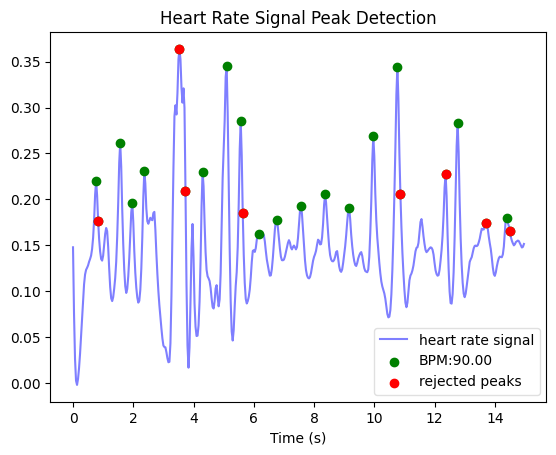

In [18]:
import heartpy as hp
working_data, measures = hp.process(_process_signal(predictions[0][:30*15]), 30, report_time=True)
print('breathing rate is: %s Hz' %measures['breathingrate'])
print('breathing rate is: %s' %(measures['breathingrate']*60))
print('rmssd',measures['rmssd'])
hp.plotter(working_data, measures)

In [19]:
print(measures['rmssd'])

146.9261773384906


In [28]:
working_data.keys()

dict_keys(['hr', 'sample_rate', 'peaklist', 'ybeat', 'rolling_mean', 'RR_list', 'RR_indices', 'RR_diff', 'RR_sqdiff', 'rrsd', 'best', 'removed_beats', 'removed_beats_y', 'binary_peaklist', 'RR_masklist', 'RR_list_cor', 'nn20', 'nn50', 'poincare'])


Finished in 0.004898 sec
breathing rate is: 0.3489183531053733 Hz
breathing rate is: 20.935101186322395
rmssd 190.8396004146408


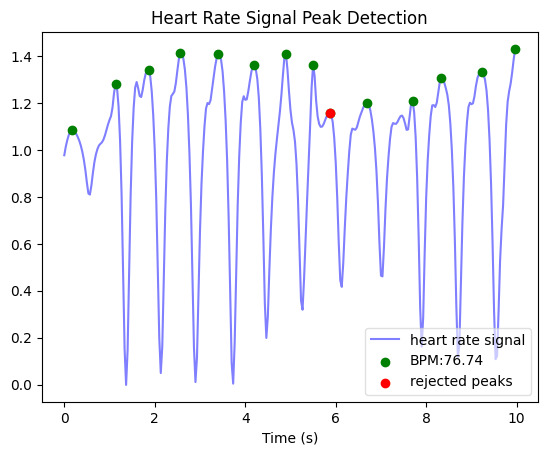

In [22]:
working_data, measures = hp.process(label[:30*10], 30, report_time=True)
print('breathing rate is: %s Hz' %measures['breathingrate'])
print('breathing rate is: %s' %(measures['breathingrate']*60))
print('rmssd',measures['rmssd'])
hp.plotter(working_data, measures)

In [23]:
measures

{'bpm': 76.74418604651163,
 'ibi': 781.8181818181819,
 'sdnn': 125.01606875597739,
 'sdsd': 105.14866345613626,
 'rmssd': 190.8396004146408,
 'pnn20': 1.0,
 'pnn50': 0.7777777777777778,
 'hr_mad': 100.0,
 'sd1': 125.43477201389703,
 'sd2': 82.40220541217403,
 's': 32471.82163657444,
 'sd1/sd2': 1.5222259087177952,
 'breathingrate': 0.3489183531053733}

In [25]:
import scipy.signal


def _next_power_of_2(x):
    """Calculate the nearest power of 2."""
    return 1 if x == 0 else 2 ** (x - 1).bit_length()
def _calculate_fft_hr(ppg_signal, fs=60, low_pass=0.75, high_pass=2.5):
    """Calculate heart rate based on PPG using Fast Fourier transform (FFT)."""
    ppg_signal = np.expand_dims(ppg_signal, 0)
    N = _next_power_of_2(ppg_signal.shape[1])
    f_ppg, pxx_ppg = scipy.signal.periodogram(ppg_signal, fs=fs, nfft=N, detrend=False)
    fmask_ppg = np.argwhere((f_ppg >= low_pass) & (f_ppg <= high_pass))
    mask_ppg = np.take(f_ppg, fmask_ppg)
    mask_pxx = np.take(pxx_ppg, fmask_ppg)
    fft_hr = np.take(mask_ppg, np.argmax(mask_pxx, 0))[0] * 60
    return fft_hr

def _calculate_peak_hr(ppg_signal, fs,promience):
    """Calculate heart rate based on PPG using peak detection."""
    ppg_peaks, _ = scipy.signal.find_peaks(ppg_signal,distance=promience)
    hr_peak = 60 / (np.mean(np.diff(ppg_peaks)) / fs)
    #hr_peak = 60 * (len(ppg_peaks) / (ppg_peaks[-1]/ fs))
    return hr_peak
def _detrend(input_signal, lambda_value):
    """Detrend PPG signal."""
    signal_length = input_signal.shape[0]
    # observation matrix
    H = np.identity(signal_length)
    ones = np.ones(signal_length)
    minus_twos = -2 * np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = spdiags(diags_data, diags_index,
                (signal_length - 2), signal_length).toarray()
    detrended_signal = np.dot(
        (H - np.linalg.inv(H + (lambda_value ** 2) * np.dot(D.T, D))), input_signal)
    return detrended_signal

In [26]:
ppg_peaks, _ = scipy.signal.find_peaks(predictions[0])
hr_peak = 60 / (np.mean(np.diff(ppg_peaks)) / fs)

In [27]:
ppg_peaks

array([   2,    5,    8, ..., 5213, 5215, 5217], dtype=int64)

In [10]:
np.diff(ppg_peaks)

array([3, 3, 2, ..., 3, 3, 2], dtype=int64)

In [11]:
np.mean(np.diff(ppg_peaks))

3.0604815032295947

In [28]:
imgs = np.load('../../data/Custom_cached/MCD-rPPG_SizeW72_SizeH72_ClipLength300_DataTypeRaw_DataAugNone_LabelTypeStandardized_Crop_faceTrue_BackendMP_MP_only_faceTrue_Large_boxTrue_Large_size1.5_Dyamic_DetTrue_det_len30_Median_face_boxFalse/0_1020_input0.npy')

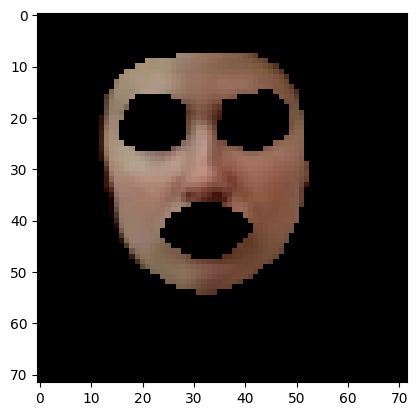

In [29]:
plt.imshow(imgs[43]/255)

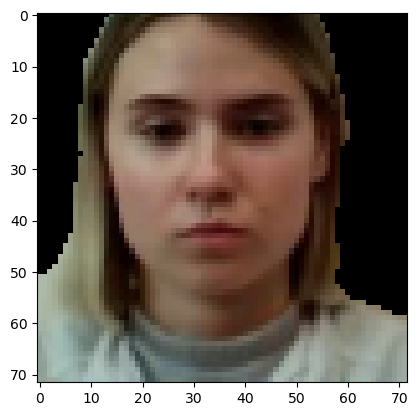

In [14]:
plt.imshow(imgs[4]/255)

In [ ]:
for idx,j in enumerate(trial_list):
    preds_fft = []
    labels = []
    label = np.array(_reform_data_from_dict(data_list[0]['labels'][j]))
    predictions = [np.array(_reform_data_from_dict(data['predictions'][j])) for data in data_list]
    print("="*25,j,"="*25)
    for idx,i in enumerate(predictions):
        print("-"*25,names[idx],"-"*25)
        print(f"\nHR(FFT):{_calculate_fft_hr(i,30,high_pass=2.45)}")
        print(f"\nHR(peak):{_calculate_peak_hr(i,30,10)}")
        print(f"\nHR(label):{_calculate_fft_hr(label,30)}")
        print(f"\nHR(error):{abs(_calculate_fft_hr(i,30,high_pass=2.45)-_calculate_fft_hr(label,30))}")
        preds_fft.append(_calculate_fft_hr(i,30,high_pass=2.45))
        labels.append(_calculate_fft_hr(label,30))
    print(f"===HR(video):{np.mean(abs(np.array(preds_fft)-np.array(labels)))}")
    
    

In [76]:
len(predictions[0])%(5*30)

120

In [30]:
_calculate_fft_hr(labels,30)

NameError: name 'labels' is not defined

In [33]:
import pandas as pd

In [31]:

file = []
preds_df = []
labels_df = []
errors = []
errors2 = []
errors_hp = []
errors_hp_frame_label = []
errors_hp_frame_pred = []
frames = [] 
model = []
for idx,j in enumerate(trial_list):
    labels = _process_signal(np.array(_reform_data_from_dict(data_list[0]['labels'][j])))
    labels_hr = _calculate_fft_hr(labels,30)
    predictions = [_process_signal(np.array(_reform_data_from_dict(data['predictions'][j]))) for data in data_list]
    print("="*25,j,"="*25)
    mae_file = []
    for seconds in [5,10,30]:
        for i,prediction in enumerate(predictions):
            print("="*25,names[i],"="*25)
            preds_fft = []
            labels_ = []
            error = []
            error_all = []
            labels_hp = []
            preds_hp = []
            errors_hp_ = []
            errors_hp_frame_label_ = []
            errors_hp_frame_pred_ = []
            frame_len = 30*seconds
            for frame in range(int(len(prediction)/(30*seconds))):
                prediction_ = prediction[frame*frame_len:(frame + 1)*frame_len]
                label = labels[frame*frame_len:(frame + 1)*frame_len]
                #preds_fft.append(_calculate_fft_hr(prediction_,30,high_pass=2.5))
                #labels_.append(_calculate_fft_hr(label,30))
                label_hr = _calculate_fft_hr(label,30)
                pred_hr = _calculate_fft_hr(prediction_,30,high_pass=2.5)
                error.append(abs(pred_hr-label_hr))
                error_all.append(abs(pred_hr-labels_hr))
                _, measures_l = hp.process(label, 30, report_time=False)
                #labels_hp.append(measures_l['bpm'])
                _, measures_p = hp.process(prediction_, 30, report_time=False)
                #preds_hp.append(measures_p['bpm'])
                errors_hp_.append(abs(measures_p['bpm'] - measures_l['bpm']))
                errors_hp_frame_label_.append(abs(label_hr - measures_l['bpm']))
                errors_hp_frame_pred_.append(abs(measures_p['bpm'] - pred_hr))

                
            mae_file.append(np.mean(np.array(error)))
            file.append(j)
            errors.append(np.mean(error))
            errors2.append(np.mean(error_all))
            errors_hp.append(np.mean(errors_hp_))
            errors_hp_frame_label.append(np.mean(errors_hp_frame_label_))
            errors_hp_frame_pred.append(np.mean(errors_hp_frame_pred_))
            frames.append(seconds)
            model.append(names[i])
        print(f"Frame: {seconds}s")
df = pd.DataFrame(data={'file':  file,
                        'error': errors2,
                        'error_frame': errors,
                        'errors_heartpy:':errors_hp,
                        'errors_heartpy_fft_label':errors_hp_frame_label,
                        'errors_heartpy_fft_pred':errors_hp_frame_pred ,
                        'Frame':frames,
                        'Model':model})

========================= 0_1020 =========================
========================= PURE_DeepPhys =========================
========================= PURE_EfficientPhys =========================
========================= PURE_iBVPNet =========================
Frame: 5s
========================= PURE_DeepPhys =========================
========================= PURE_EfficientPhys =========================
========================= PURE_iBVPNet =========================
Frame: 10s
========================= PURE_DeepPhys =========================
========================= PURE_EfficientPhys =========================
========================= PURE_iBVPNet =========================
Frame: 30s
========================= 1_1020 =========================
========================= PURE_DeepPhys =========================
========================= PURE_EfficientPhys =========================
========================= PURE_iBVPNet =========================
Frame: 5s
========================= PURE_D

e:\Anaconda\envs\rppg-toolbox\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\Anaconda\envs\rppg-toolbox\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


========================= PURE_iBVPNet =========================
Frame: 5s
========================= PURE_DeepPhys =========================
========================= PURE_EfficientPhys =========================
========================= PURE_iBVPNet =========================
Frame: 10s
========================= PURE_DeepPhys =========================
========================= PURE_EfficientPhys =========================
========================= PURE_iBVPNet =========================
Frame: 30s
========================= 3_1020 =========================
========================= PURE_DeepPhys =========================
========================= PURE_EfficientPhys =========================
========================= PURE_iBVPNet =========================
Frame: 5s
========================= PURE_DeepPhys =========================
========================= PURE_EfficientPhys =========================
========================= PURE_iBVPNet =========================
Frame: 10s
===============

NameError: name 'pd' is not defined

In [66]:
len(preds_hp),len(file)

(0, 90)

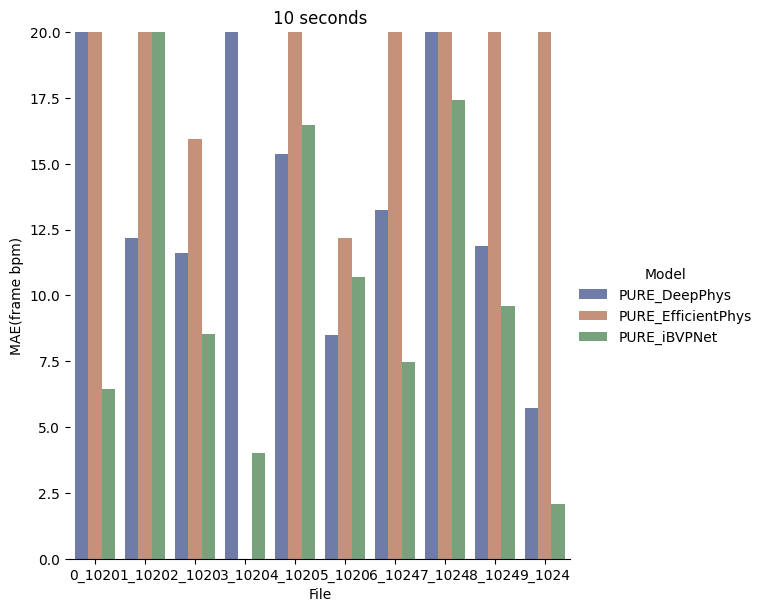

In [34]:
import seaborn as sns
g = sns.catplot(
    data=df[df['Frame'] == 10], kind="bar",
    x="file",y='errors_heartpy:', hue="Model",
    errorbar="sd", palette="dark", alpha=.6, height=6,
)
g.despine(left=True)
g.set_axis_labels("File", "MAE(frame bpm)")
g.legend.set_title("Model")
g.set(title='10 seconds')
g.set(ylim=(0, 20))

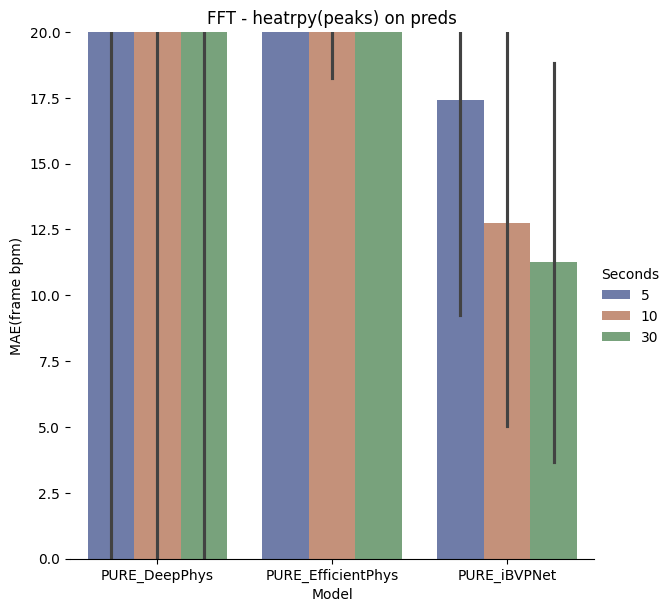

In [35]:
import seaborn as sns
g = sns.catplot(
    data=df, kind="bar",
    x="Model",y='errors_heartpy_fft_pred', hue="Frame",
    errorbar="sd", palette="dark", alpha=.6, height=6,
)
g.despine(left=True)
g.set_axis_labels("Model", "MAE(frame bpm)")
g.legend.set_title("Seconds")
g.set(title='FFT - heatrpy(peaks) on preds')
g.set(ylim=(0, 20))

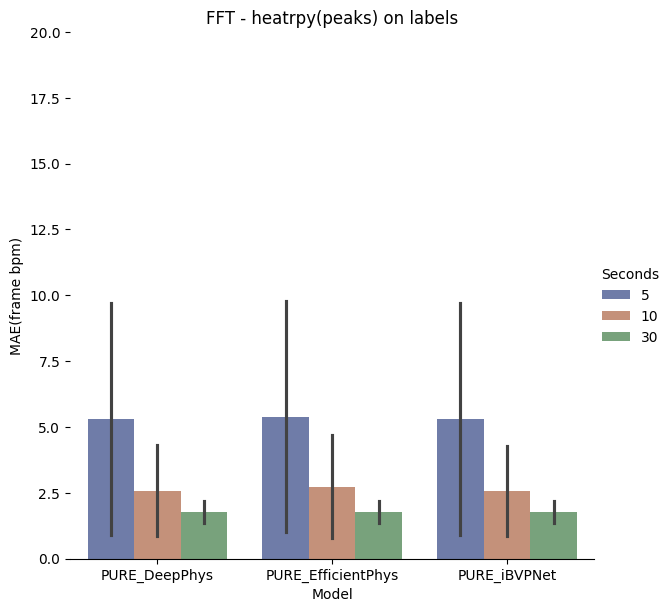

In [37]:
import seaborn as sns
g = sns.catplot(
    data=df, kind="bar",
    x="Model",y='errors_heartpy_fft_label', hue="Frame",
    errorbar="sd", palette="dark", alpha=.6, height=6,
)
g.despine(left=True)
g.set_axis_labels("Model", "MAE(frame bpm)")
g.legend.set_title("Seconds")
g.set(title='FFT - heatrpy(peaks) on labels')
g.set(ylim=(0, 20))

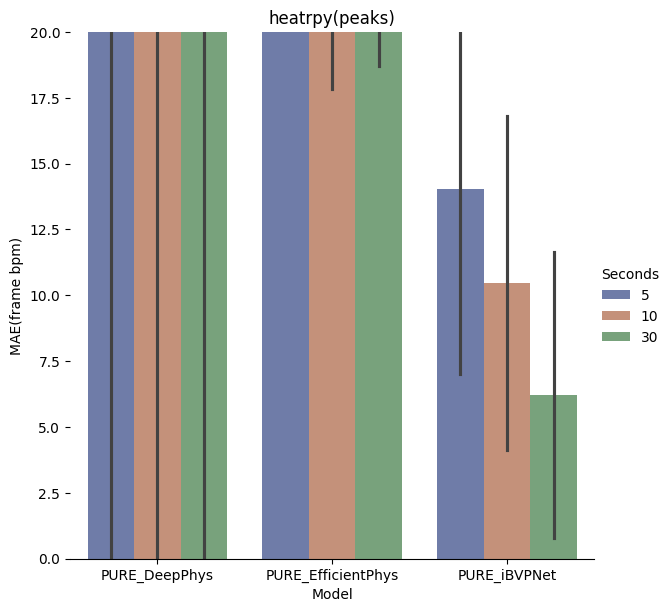

In [39]:
import seaborn as sns
g = sns.catplot(
    data=df, kind="bar",
    x="Model",y='errors_heartpy:', hue="Frame",
    errorbar="sd", palette="dark", alpha=.6, height=6,
)
g.despine(left=True)
g.set_axis_labels("Model", "MAE(frame bpm)")
g.legend.set_title("Seconds")
g.set(title='heatrpy(peaks), face landmarks')
g.set(ylim=(0, 20))

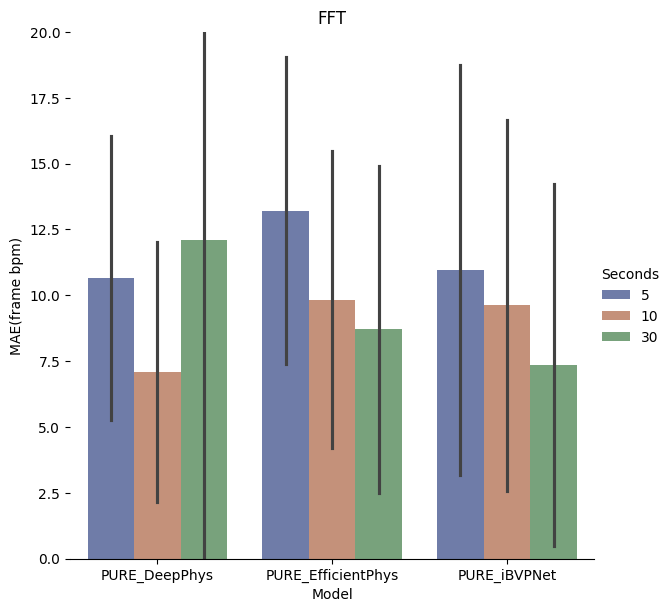

In [40]:
import seaborn as sns
g = sns.catplot(
    data=df, kind="bar",
    x="Model",y="error_frame", hue="Frame",
    errorbar="sd", palette="dark", alpha=.6, height=6,
)
g.despine(left=True)
g.set_axis_labels("Model", "MAE(frame bpm)")
g.legend.set_title("Seconds")
g.set(title='FFT')
g.set(ylim=(0, 20))

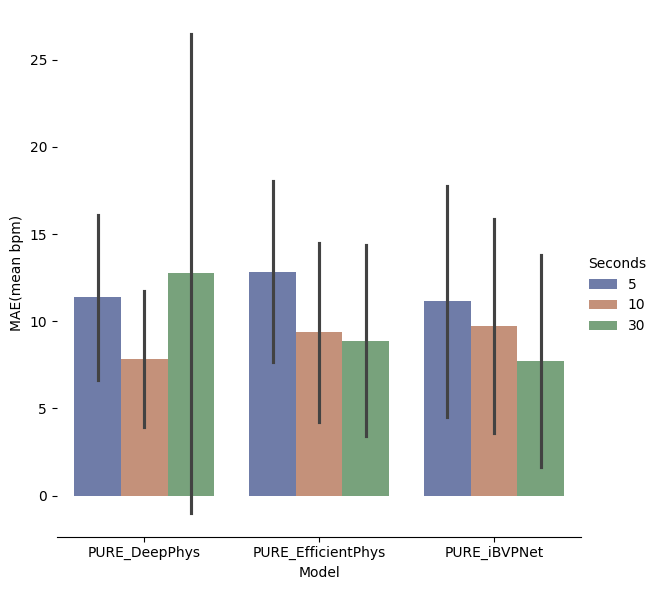

In [41]:
import seaborn as sns
g = sns.catplot(
    data=df, kind="bar",
    x="Model",y="error", hue="Frame",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Model", "MAE(mean bpm)")
g.legend.set_title("Seconds")

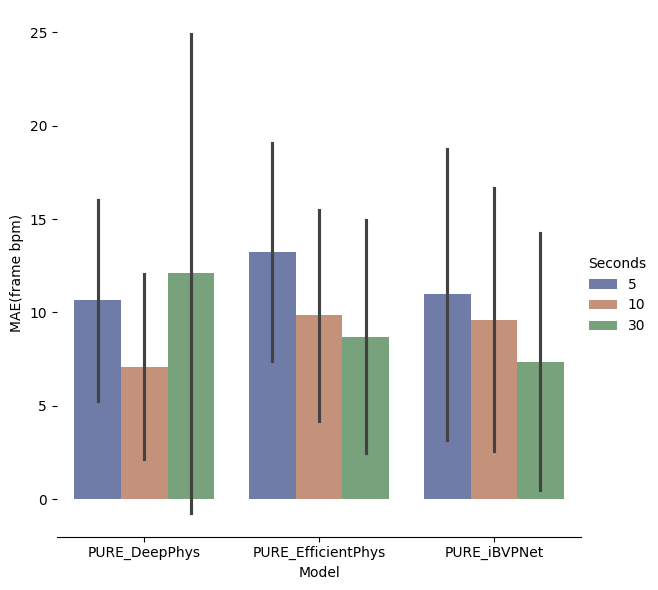

In [42]:
import seaborn as sns
g = sns.catplot(
    data=df, kind="bar",
    x="Model",y="error_frame", hue="Frame",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Model", "MAE(frame bpm)")
g.legend.set_title("Seconds")

In [115]:
df.to_clipboard()

ImportError: cannot import name 'PyperclipException' from 'pandas.errors' (e:\Anaconda\envs\rppg-toolbox\lib\site-packages\pandas\errors\__init__.py)

In [46]:
ppg_signal = predictions[0][:50]
fs=60
low_pass=0.75
high_pass=2.5
"""Calculate heart rate based on PPG using Fast Fourier transform (FFT)."""
ppg_signal2 = np.expand_dims(ppg_signal, 0)
N = _next_power_of_2(ppg_signal2.shape[1])
f_ppg, pxx_ppg = scipy.signal.periodogram(ppg_signal2, fs=fs, nfft=N, detrend=False)
fmask_ppg = np.argwhere((f_ppg >= low_pass) & (f_ppg <= high_pass))
mask_ppg = np.take(f_ppg, fmask_ppg)
mask_pxx = np.take(pxx_ppg, fmask_ppg)
fft_hr = np.take(mask_ppg, np.argmax(mask_pxx, 0))[0] * 60

In [62]:
np.argmax(mask_pxx, 0)

array([1], dtype=int64)

In [61]:
mask_ppg

array([[0.9375],
       [1.875 ]])

In [57]:
fmask_ppg

array([[1],
       [2]], dtype=int64)

In [54]:
f_ppg

array([ 0.    ,  0.9375,  1.875 ,  2.8125,  3.75  ,  4.6875,  5.625 ,
        6.5625,  7.5   ,  8.4375,  9.375 , 10.3125, 11.25  , 12.1875,
       13.125 , 14.0625, 15.    , 15.9375, 16.875 , 17.8125, 18.75  ,
       19.6875, 20.625 , 21.5625, 22.5   , 23.4375, 24.375 , 25.3125,
       26.25  , 27.1875, 28.125 , 29.0625, 30.    ])

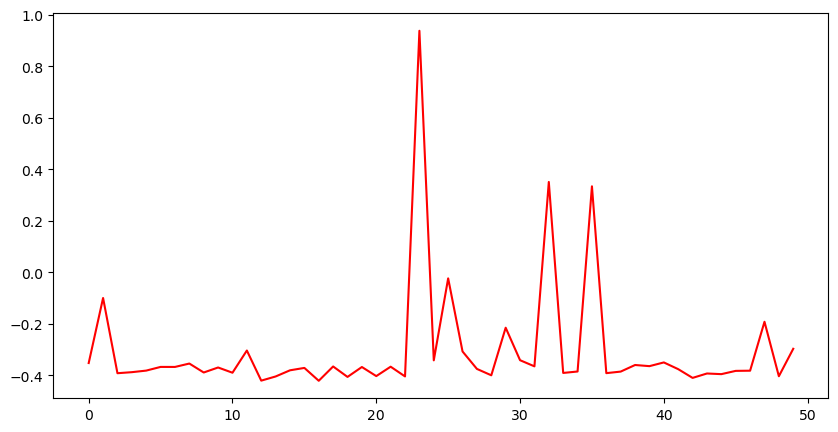

In [56]:
ppg_signal = predictions[0][:50]
plt.figure(figsize=(10,5))
plt.plot(range(0,len(ppg_signal)),ppg_signal,color='r')

In [52]:
ppg_signal2 = ppg_signal2[0]

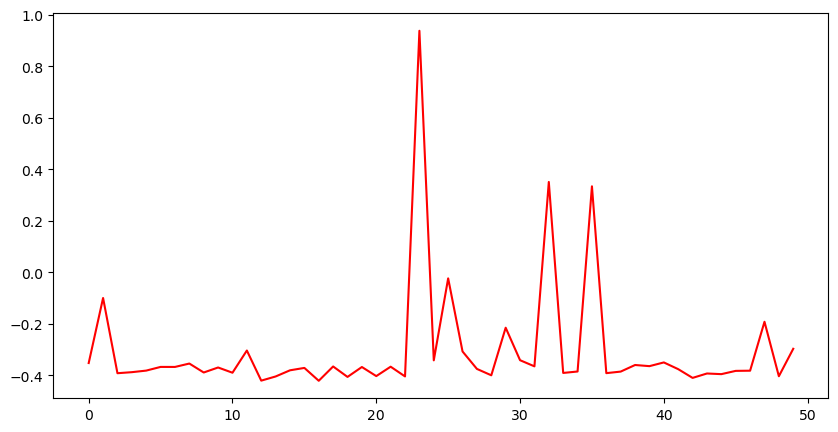

In [53]:
plt.figure(figsize=(10,5))
plt.plot(range(0,len(ppg_signal2)),ppg_signal2,color='r')

# MCD(10):
## EfficientPhys:
* FFT MAE (FFT Label): 4.921875 +/- 2.254141810122065
* FFT RMSE (FFT Label): 8.662355714066978 +/- 6.937509733634752
* FFT MAPE (FFT Label): 6.097925955558018 +/- 2.7856795854835736
* FFT Pearson (FFT Label): 0.8364525451300041 +/- 0.19376117378926125
* FFT SNR (FFT Label): -7.4213260674769455 +/- 5.850195189791329 (dB)
## DeepPhys:
* FFT MAE (FFT Label): 10.37109375 +/- 4.593367891573819
* FFT RMSE (FFT Label): 17.847965470739297 +/- 13.843402871929264
* FFT MAPE (FFT Label): 11.268475472756826 +/- 4.775487061172975
* FFT Pearson (FFT Label): -0.5830276044568388 +/- 0.2872452811712753
* FFT SNR (FFT Label): 1.184364002535987 +/- 1.794606870439465 (dB)
## iBVP:
* FFT MAE (FFT Label): 7.18505859375 +/- 2.8205651040694395
* FFT RMSE (FFT Label): 11.453424905178505 +/- 8.770854375225511
* FFT MAPE (FFT Label): 8.037377902538648 +/- 2.9827186995055066
* FFT Pearson (FFT Label): 0.2670398280598101 +/- 0.3407142736644935
* FFT SNR (FFT Label): 2.065927596572459 +/- 2.2838576152000467 (dB)


# MCD(10, face landmarks):
## EfficientPhys:
* FFT RMSE (FFT Label): 20.864538346646953 +/- 15.429330089413737
* FFT MAPE (FFT Label): 15.956246502453295 +/- 4.94755427553977
* FFT Pearson (FFT Label): -0.13334531721043222 +/- 0.350396030652826
* FFT SNR (FFT Label): -6.782290617226801 +/- 4.896615852856688 (dB)
## DeepPhys:
* FFT MAE (FFT Label): 10.0634765625 +/- 4.166910196181138
* FFT RMSE (FFT Label): 16.580258331955207 +/- 12.341688894276805
* FFT MAPE (FFT Label): 11.034827786762246 +/- 4.352171592087004
* FFT Pearson (FFT Label): -0.5099725496923818 +/- 0.30412332995025454
* FFT SNR (FFT Label): -0.3069666563016405 +/- 1.8778683435965884 (dB)
FFT MAE (FFT Label): 14.1943359375 +/- 4.835801771289815
## iBVP:
* FFT MAE (FFT Label): 4.74609375 +/- 1.6144146574778415
* FFT RMSE (FFT Label): 6.970563301956452 +/- 5.465035468917493
* FFT MAPE (FFT Label): 5.420584973245718 +/- 1.7110202011597444
* FFT Pearson (FFT Label): 0.7381262394827584 +/- 0.23852925779321119
* FFT SNR (FFT Label): 1.955567456892998 +/- 1.9305683295864862 (dB)

# SCAMPS:
## IBVP:
* FFT MAE (FFT Label): 4.04296875 +/- 2.319380139381432
* FFT RMSE (FFT Label): 8.375012753605029 +/- 7.0510854929005164
* FFT MAPE (FFT Label): 7.628364389233953 +/- 4.648301128453836
* FFT Pearson (FFT Label): 0.9808389916728781 +/- 0.06887930786358451
* FFT SNR (FFT Label): 1.251393206943043 +/- 1.2195997199767343 (dB)
## DeepPhys:
* FFT MAE (FFT Label): 4.5703125 +/- 4.335779135621489
* FFT RMSE (FFT Label): 14.452597118738296 +/- 14.07688373922655
* FFT MAPE (FFT Label): 3.209876543209876 +/- 3.0451562653473276
* FFT Pearson (FFT Label): 0.9095020070478775 +/- 0.14697197827131986
* FFT SNR (FFT Label): 10.036827955707176 +/- 1.7386446346749485 (dB)
## EfficientPhys:
* FFT MAE (FFT Label): 41.1328125 +/- 8.726259996435507
* FFT RMSE (FFT Label): 49.53165048142513 +/- 25.131511378785174
* FFT MAPE (FFT Label): 32.73815986315986 +/- 6.457214261093649
* FFT Pearson (FFT Label): 0.10501146474898267 +/- 0.3515985978838783
* FFT SNR (FFT Label): -9.845184316144397 +/- 2.594869676697503 (dB)

In [19]:
predictions

[array([-0.35173705, -0.09937134, -0.39119694, ..., -0.41959456,
        -0.42800543, -0.34071293], dtype=float32),
 array([ 0.11004296, -0.1980536 ,  0.24233133, ..., -0.32563382,
        -0.32225662, -0.07041693], dtype=float32),
 array([0.17602035, 0.1883862 , 0.16939652, ..., 0.1785805 , 0.20172594,
        0.1765299 ], dtype=float32)]

In [20]:
label

array([-3.300962  , -2.447265  , -1.3659153 , ...,  0.5691314 ,
        0.51221824,  0.39839196], dtype=float32)

In [21]:
names

['PURE_DeepPhys', 'PURE_EfficientPhys', 'PURE_iBVPNet', 'Labels']

In [22]:
data_list[0]['labels']

{'0_1020': {0: tensor([[ 0.1067],
          [-0.0534],
          [-1.4942],
          [-2.2413],
          [-0.8005],
          [ 0.3202],
          [ 0.5336],
          [ 0.2135],
          [ 0.2135],
          [ 0.4269],
          [-0.6937],
          [-0.0534],
          [-0.2135],
          [ 0.1601],
          [ 0.3735],
          [ 0.3735],
          [ 0.3202],
          [ 0.4803],
          [ 0.3202],
          [ 0.2135],
          [ 0.1067],
          [ 0.1601],
          [ 0.3735],
          [-0.1067],
          [-3.4153],
          [-1.1740],
          [ 0.0000],
          [ 0.0000],
          [ 0.0000],
          [ 0.0534],
          [ 0.3735],
          [ 0.5336],
          [ 0.5336],
          [ 0.2135],
          [-0.1067],
          [ 0.2135],
          [ 0.5336],
          [ 0.4269],
          [ 0.3735],
          [ 0.2668],
          [ 0.3202],
          [ 0.2668],
          [ 0.2135],
          [ 0.2668],
          [ 0.1601],
          [ 0.2135],
          [-0.0534],
